In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

#import mlflow

2.7.0


In [3]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from deepgar_skew import QuantileLossModel, model_deepgar_skew_v2
from chart_tools import loss_figure, train_dist_figure, test_dist_figure, get_cycle
from sample_creation import sample_creation, created_naive_forecast, import_latest_data, import_data, invert_scale, invert_normalize

In [6]:
def rmse(y, f):
    assert y.shape[0] == f.shape[0]
    assert y.shape[0] > 0 and y.shape[0] is not None
    return np.sum(((y-f)**2))/y.shape[0]

def sum_neg_like(prob):
    return np.sum(np.log(prob))

In [7]:
def return_density(cond_quant):
    initial_estimates = np.array([1., 1., 1., 3.])

    parameters_est = optimize.leastsq(opt, initial_estimates, (cond_quant, ))

    #print(parameters_est)

    dist_result = SST( 
                  mu = parameters_est[0][0], 
                  sigma = parameters_est[0][1], 
                  nu = parameters_est[0][2],
                  tau = parameters_est[0][3]
                  )

    return dist_result, parameters_est

def opt(parameters, data):
    quantiles_config = [
             0.05,
             0.25,
             0.75,
             0.95]
    dist = SST(mu = parameters[0], sigma = parameters[1], nu = parameters[2], tau = parameters[3])
    error = dist.q(quantiles_config) - data
    return error

In [8]:
def generate_quantiles(num_quantiles):
    '''
    Create equally spaced quantiles
    '''
    return np.linspace(0.01, 0.99 , num_quantiles).tolist()

In [9]:
# Define the model parameters
param = {
    'NUM_FEATURES': 0,
    'NUM_QUANTILES': 2,
    'SPLIT': 0.75,
    'WINDOW_SIZE': 1,
    '1_COMMON_LSTM_NUM': 128,
    '2_COMMON_LSTM_NUM': 128,
    '1_IND_LSTM_NUM': 64,
    '1_IND_DENSE_NUM': 32,
    '1_IND_DENSE_ACTIVATION': 'relu',
    '1_OUT_DENSE_ACTIVATION': None,
    '1_LEARNING_RATE': 0.001,
    '2_SELECTION_METHOD': "weights", # "weights", "softmax_relu"
    '2_LSTM_NUM': 32,
    '2_DENSE_1_NUM': 16,
    '2_DENSE_1_ACTIVATION': None,
    '2_DENSE_2_ACTIVATION': 'tanh',
    '2_LEARNING_RATE': 0.001,
    'PRED_STEP': 1
}

EPOCHS1 = 95
EPOCHS2 = 2000

# Generate quantiles
#param['QUANTILES'] = generate_quantiles(param['NUM_QUANTILES'])
param['QUANTILES'] = [0.05, 0.25, 0.75, 0.95]

# EPOCHS
# Bulgaria   125
# Estonia    95
# Lithuania  150
# Romania    


In [10]:
patience = int(EPOCHS1*0.10)
patience

9

In [13]:
country = "Lithuania"

# Import and generate modeling sample
#dataset = import_latest_data()

datafile = "data_"+country+"_19.07.2022.csv"

#datafile = "data_23.04.2021_17.49.28_bg_v3.csv"

#datafile = "data_23.04.2021_17.49.28.csv"

dataset = import_data(datafile)

# exclude risk factors
#dataset = dataset.drop(['BRENT'], axis=1) # sufficient

# leave only gdp
dataset = dataset[['GDP', 'SENTIMENT', 'LT_BOND_YIELD']]

data, scaler = sample_creation(dataset, param, prediction_step = param['PRED_STEP'])

naive = created_naive_forecast(data['TEST_DF'], param['WINDOW_SIZE'])
if isinstance(dataset, pd.DataFrame):
    param['NUM_FEATURES'] = data['TRAIN_DF'].shape[1]
else:
    param['NUM_FEATURES'] = 1

data/data_Lithuania_19.07.2022.csv


In [14]:
len(dataset)*(param['SPLIT'])

56.25

In [15]:
param['NUM_FEATURES']

3

In [16]:
import time
start = time.time()
# Estimate the models
y_train_dist, y_test_dist, history1, model1 = model_deepgar_skew_v2(param, data, EPOCHS1, 50)
end = time.time()
print("Training took:" + str(round(end - start, 2)) + " sec")
model1.summary()

2022-08-18 13:46:14.696694: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/95
1/2 [==============>...............] - ETA: 1s - loss: 2.5872
Loss_weights used: 0.95 0.05
2/2 [==============================] - 2s 466ms/step - loss: 2.5721 - val_loss: 2.1812
Epoch 2/95
1/2 [==============>...............] - ETA: 0s - loss: 2.4190
Loss_weights used: 0.95 0.05
2/2 [==============================] - 0s 11ms/step - loss: 2.4087 - val_loss: 2.0325
Epoch 3/95
1/2 [==============>...............] - ETA: 0s - loss: 2.2849
Loss_weights used: 0.95 0.05
2/2 [==============================] - 0s 11ms/step - loss: 2.2993 - val_loss: 1.9138
Epoch 4/95
1/2 [==============>...............] - ETA: 0s - loss: 2.2000
Loss_weights used: 0.95 0.05
2/2 [==============================] - 0s 11ms/step - loss: 2.1992 - val_loss: 1.8115
Epoch 5/95
1/2 [==============>...............] - ETA: 0s - loss: 2.1233
Loss_weights used: 0.95 0.05
2/2 [==============================] - 0s 11ms/step - loss: 2.1030 - val_loss: 1.7143
Epoch 6/95
1/2 [==============>...............] - ETA: 0s -

Epoch 45/95
1/2 [==============>...............] - ETA: 0s - loss: 0.5233
Loss_weights used: 0.95 0.05
2/2 [==============================] - 0s 10ms/step - loss: 0.5197 - val_loss: 0.7244
Epoch 46/95
1/2 [==============>...............] - ETA: 0s - loss: 0.5196
Loss_weights used: 0.95 0.05
2/2 [==============================] - 0s 10ms/step - loss: 0.5148 - val_loss: 0.7221
Epoch 47/95
1/2 [==============>...............] - ETA: 0s - loss: 0.5131
Loss_weights used: 0.95 0.05
2/2 [==============================] - 0s 11ms/step - loss: 0.5098 - val_loss: 0.7190
Epoch 48/95
1/2 [==============>...............] - ETA: 0s - loss: 0.5095
Loss_weights used: 0.95 0.05
2/2 [==============================] - 0s 10ms/step - loss: 0.5051 - val_loss: 0.7141
Epoch 49/95
1/2 [==============>...............] - ETA: 0s - loss: 0.5047
Loss_weights used: 0.95 0.05
2/2 [==============================] - 0s 10ms/step - loss: 0.4997 - val_loss: 0.7097
Epoch 50/95
1/2 [==============>...............] - ETA:

1/2 [==============>...............] - ETA: 0s - loss: 0.3830
Loss_weights used: 0.05 0.95
2/2 [==============================] - 0s 9ms/step - loss: 0.3805 - val_loss: 0.7126
Epoch 89/95
1/2 [==============>...............] - ETA: 0s - loss: 0.3813
Loss_weights used: 0.05 0.95
2/2 [==============================] - 0s 9ms/step - loss: 0.3788 - val_loss: 0.7067
Epoch 90/95
1/2 [==============>...............] - ETA: 0s - loss: 0.3798
Loss_weights used: 0.05 0.95
2/2 [==============================] - 0s 10ms/step - loss: 0.3766 - val_loss: 0.7020
Epoch 91/95
1/2 [==============>...............] - ETA: 0s - loss: 0.3723
Loss_weights used: 0.05 0.95
2/2 [==============================] - 0s 10ms/step - loss: 0.3754 - val_loss: 0.6997
Epoch 92/95
1/2 [==============>...............] - ETA: 0s - loss: 0.3778
Loss_weights used: 0.05 0.95
2/2 [==============================] - 0s 10ms/step - loss: 0.3731 - val_loss: 0.7030
Epoch 93/95
1/2 [==============>...............] - ETA: 0s - loss: 0.

(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Training and Validation Loss - Simultaneous Quantiles Generation & Crossing Loss'}, xlabel='Epochs', ylabel='Loss'>)

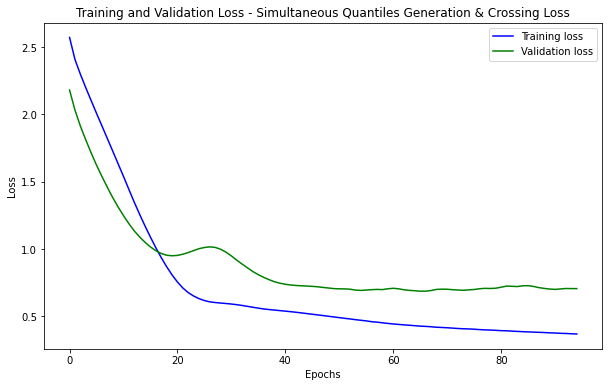

In [17]:
loss_figure(history1)

In [18]:
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model1, "charts/1step_quantile_model.png", show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [19]:
'''
with mlflow.start_run():
    
    # Logging params and metrics to MLFlow
    mlflow.log_param('data file', datafile)
    if isinstance(dataset, pd.DataFrame):    
        mlflow.log_param('features', dataset.columns)
    else:
        mlflow.log_param('features', "GDP")
    mlflow.log_param('quantiles', param['QUANTILES'])
    mlflow.log_param('learning rate', param['1_LEARNING_RATE'])
    mlflow.log_param('lag lenght', param['WINDOW_SIZE'])
    mlflow.log_param('split', param['SPLIT'])
    mlflow.log_param('epochs', EPOCHS1)
    mlflow.log_param('common LSTM units', param['1_COMMON_LSTM_NUM'])
    mlflow.log_param('branch LSTM units', param['1_IND_LSTM_NUM'])
    mlflow.log_param('dense layer units', param['1_IND_DENSE_NUM'])
    mlflow.log_param('dense layer activation', param['1_IND_DENSE_ACTIVATION'])
    mlflow.log_param('out layer activation', param['1_OUT_DENSE_ACTIVATION'])
    
    mlflow.log_metric('loss', history1.history['loss'][-1])
    mlflow.log_metric('mae', history1.history['mae'][-1])
    mlflow.log_metric('mse', history1.history['mse'][-1])
    mlflow.log_metric('val_loss', history1.history['val_loss'][-1])
    mlflow.log_metric('val_mae', history1.history['val_mae'][-1])
    mlflow.log_metric('val_mse', history1.history['val_mse'][-1])
    # Logging figures
    
    # Reshaping the output
    if len(y_test_dist.shape) > 2:
        y_test_dist = y_test_dist.squeeze()   
    
    if len(y_train_dist.shape) > 2:
        y_train_dist = y_train_dist.squeeze() 
    
    fig1, ax1 = loss_figure(history1)
    fig2, ax2 = train_dist_figure(y_train_dist, param['QUANTILES'], data)
    fig3, ax3 = test_dist_figure(y_test_dist, param['QUANTILES'], data)

    mlflow.log_figure(fig1, "loss_figure.png")
    mlflow.log_figure(fig2, "train_dist.png")
    mlflow.log_figure(fig3, "test_dist.png")
    
    # Logging model to MLFlow
    #mlflow.tensorflow.log_model(model1, 'Quantile model')
'''

'\nwith mlflow.start_run():\n    \n    # Logging params and metrics to MLFlow\n    mlflow.log_param(\'data file\', datafile)\n    if isinstance(dataset, pd.DataFrame):    \n        mlflow.log_param(\'features\', dataset.columns)\n    else:\n        mlflow.log_param(\'features\', "GDP")\n    mlflow.log_param(\'quantiles\', param[\'QUANTILES\'])\n    mlflow.log_param(\'learning rate\', param[\'1_LEARNING_RATE\'])\n    mlflow.log_param(\'lag lenght\', param[\'WINDOW_SIZE\'])\n    mlflow.log_param(\'split\', param[\'SPLIT\'])\n    mlflow.log_param(\'epochs\', EPOCHS1)\n    mlflow.log_param(\'common LSTM units\', param[\'1_COMMON_LSTM_NUM\'])\n    mlflow.log_param(\'branch LSTM units\', param[\'1_IND_LSTM_NUM\'])\n    mlflow.log_param(\'dense layer units\', param[\'1_IND_DENSE_NUM\'])\n    mlflow.log_param(\'dense layer activation\', param[\'1_IND_DENSE_ACTIVATION\'])\n    mlflow.log_param(\'out layer activation\', param[\'1_OUT_DENSE_ACTIVATION\'])\n    \n    mlflow.log_metric(\'loss\', hi

In [20]:
yhat = model1([data['X_TEST'], data['Y_TEST']])
#yhat

In [21]:
m = yhat[0]#*scaler['std'][0] + scaler['mean'][0]
s = yhat[1]
a = yhat[2]
t = yhat[3]
#pd.DataFrame(np.array(tf.squeeze(m)))
#np.squeeze(np.array(m), axis=2).shape

In [22]:
pd_list = [pd.DataFrame(np.array(tf.squeeze(m)), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(np.array(tf.squeeze(s)), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(np.array(tf.squeeze(a)), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(np.array(tf.squeeze(t)), index = data['TEST_DF'].index.to_list()[1:])]

final_df = (pd.concat(pd_list, axis=1))
final_df.set_axis(['LOC', 'STDEV', 'SKEWNESS', 'TAILWEIGHT'], axis=1, inplace=True)
final_df

,LOC,STDEV,SKEWNESS,TAILWEIGHT
2017Q3,0.151064,0.404637,0.100855,1.541978
2017Q4,0.139657,0.523347,-0.026987,1.412133
2018Q1,0.183352,0.517166,-0.070685,1.462927
2018Q2,0.108495,0.425870,0.075521,1.495890
2018Q3,0.180799,0.490890,0.016440,1.454070
2018Q4,0.105171,0.523793,-0.035387,1.400413
2019Q1,0.146664,0.537458,-0.032697,1.393154
2019Q2,0.120730,0.469037,0.030244,1.436498
2019Q3,-0.024814,0.379660,0.052662,1.485921
2019Q4,0.037161,0.513434,-0.046487,1.393078


In [23]:
def denormalize(x, scaler):
    return (x*scaler['std'][0] + scaler['mean'][0])*100

In [24]:
#from skewnormal_v2 import SkewNormal
#dist = SkewNormal(loc=list(np.squeeze(m)), scale=list(np.squeeze(s)), skewness=list(np.squeeze(a))
dist = tfp.distributions.SinhArcsinh(loc=list(np.squeeze(m)), 
                                     scale=list(np.squeeze(s)), 
                                     skewness=list(np.squeeze(a)), 
                                     tailweight=list(np.squeeze(t)))

Text(0.5, 1.0, 'Lithuania')

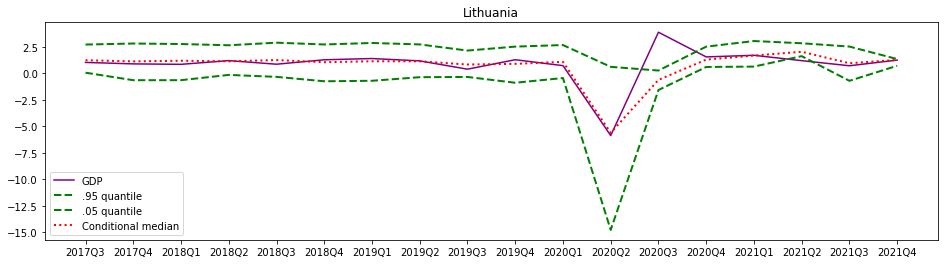

In [27]:
real_y = denormalize(data['Y_TEST'], scaler)
m = denormalize(m, scaler)
upper = denormalize(np.array(dist.quantile(0.95)), scaler)
lower = denormalize(np.array(dist.quantile(0.05)), scaler)
median = denormalize(np.array(dist.quantile(0.5)), scaler)

plt.figure(figsize=[16, 4])  # inches

plt.plot(real_y.squeeze(), label='GDP', color='purple');
#plt.plot(m, 'r', linewidth=4, label='mean');
plt.plot(upper, 'g', linewidth=2, label=r'.95 quantile', linestyle="--");
plt.plot(lower, 'g', linewidth=2, label=r'.05 quantile', linestyle="--");
plt.plot(median, 'r', linewidth=2, label=r'Conditional median', linestyle="dotted");
#plt.plot((naive*scaler['std'][0] + scaler['mean'][0])*100, label="Naive Prediction", color='c');

ax=plt.gca();
ax.set_xticks(range(len(data['TEST_DF'])-1))
ax.set_xticklabels(data['TEST_DF'].index.to_list()[1:])
#ax.xaxis.set_ticks_position('bottom')
#ax.yaxis.set_ticks_position('left')
#ax.spines['left'].set_position(('data', 0))
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend()
plt.title(country)
#plt.savefig('data/deepgar_'+country.lower()+'.png')

In [28]:
real_y.min()

-5.8640365

In [29]:
median.min()

-5.603786

In [30]:
data['Y_TEST']

array([[ 8.27549239e-02],
       [ 1.73591854e-02],
       [-2.44187258e-03],
       [ 1.62318617e-01],
       [ 3.00023550e-03],
       [ 1.99208004e-01],
       [ 2.55201535e-01],
       [ 1.50900641e-01],
       [-2.17644250e-01],
       [ 2.02012256e-01],
       [-6.04784053e-02],
       [-3.16249779e+00],
       [ 1.42107094e+00],
       [ 3.26822268e-01],
       [ 3.98520979e-01],
       [ 1.60896150e-01],
       [-6.57521406e-02],
       [ 1.85165811e-01]])

In [31]:
dist_prob = pd.DataFrame(np.array(dist.prob(np.squeeze(data['Y_TEST']))), index = data['TEST_DF'].index.to_list()[1:])

dist_prob

,0
2017Q3,1.360231
2017Q4,0.930860
2018Q1,0.861318
2018Q2,1.292431
2018Q3,0.895899
2018Q4,0.955779
2019Q1,0.914920
2019Q2,1.149834
2019Q3,0.964374
2019Q4,0.872770


In [32]:
recession = np.full(np.squeeze(real_y).shape, -0.001)
dist_cdf = pd.DataFrame(np.array(dist.cdf(list(recession))), index = data['TEST_DF'].index.to_list()[1:])
dist_cdf

,0
2017Q3,0.259853
2017Q4,0.373050
2018Q1,0.344690
2018Q2,0.330087
2018Q3,0.305129
2018Q4,0.409410
2019Q1,0.374269
2019Q2,0.352453
2019Q3,0.514364
2019Q4,0.479620


In [33]:
#country = datafile[datafile.find('/data_')+len('/data_'):datafile.rfind('_')]

In [35]:
pd_list = [pd.DataFrame(real_y.squeeze(), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(median, index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(np.sqrt(np.power((real_y.squeeze()-median),2)), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(lower, index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(upper, index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(upper-lower, index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(list(denormalize(np.squeeze(m), scaler)), index = data['TEST_DF'].index.to_list()[1:]), 
           pd.DataFrame(list(np.squeeze(s)), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(list(np.squeeze(a)), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(list(np.squeeze(t)), index = data['TEST_DF'].index.to_list()[1:]),
           dist_prob,
           dist_cdf]

final_df = (pd.concat(pd_list, axis=1))
final_df.set_axis(['GDP Actual', 
                   'Median',
                   'RMSE',
                   '.05 Quantile',
                   '.95 Quantile',
                   'IQR',
                   'Location', 
                   'Standard Deviation', 
                   'Skewness',
                   'Tailweight',
                   'Predictive Score', 
                   'Probability of recession'], axis=1, inplace=True)

#country = 'BG'

#final_df.to_csv('data/small_countries/'+'results_deepgar_'+country +'.csv')
#print("Exporting file to csv format at "+now.strftime('%d.%m.%Y_%H.%M.%S'))

(array([ 9., 15.,  9.,  9., 13.]),
 array([0.00197414, 0.19186981, 0.38176548, 0.5716612 , 0.7615568 ,
        0.9514525 ], dtype=float32),
 <BarContainer object of 5 artists>)

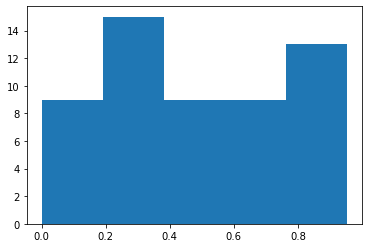

In [36]:
yhat_train = model1([data['X_TRAIN'], data['Y_TRAIN']])

m_train = yhat_train[0]
s_train = yhat_train[1]
a_train = yhat_train[2]
t_train = yhat_train[3]

dist_train = tfp.distributions.SinhArcsinh(loc=list(np.squeeze(m_train)), 
                                     scale=list(np.squeeze(s_train)), 
                                     skewness=list(np.squeeze(a_train)), 
                                     tailweight=list(np.squeeze(t_train)))

pit = pd.DataFrame(np.array(dist_train.cdf(np.squeeze(data['Y_TRAIN']))), index = data['TRAIN_DF'].index.to_list()[1:])

plt.hist(pit, 5)
#pit

In [37]:
denormalize(data['Y_TEST'], scaler)
#real_y

array([[ 1.036133 ],
       [ 0.8970863],
       [ 0.8549846],
       [ 1.2053041],
       [ 0.8665558],
       [ 1.2837396],
       [ 1.402795 ],
       [ 1.1810268],
       [ 0.3974138],
       [ 1.2897021],
       [ 0.7315853],
       [-5.8640365],
       [ 3.8817072],
       [ 1.5550775],
       [ 1.7075258],
       [ 1.2022796],
       [ 0.7203721],
       [ 1.2538826]])

In [38]:
print(rmse(real_y, np.squeeze(median)))

104.21731300479571


In [39]:
print(sum_neg_like(np.array(dist_prob)))

-15.024492


In [40]:
yhat = model1([data['X_TRAIN'], data['Y_TRAIN']])
#yhat

In [41]:
m = yhat[0]
s = yhat[1]
a = yhat[2]
t = yhat[3]
pd.DataFrame(np.array(s))

,0
0,0.527162
1,0.356949
2,0.520349
3,0.428795
4,0.450352
5,0.545496
6,0.534286
7,0.438093
8,0.384087
9,0.423028


In [42]:
dist = tfp.distributions.SinhArcsinh(loc=list(np.squeeze(m)), scale=list(np.squeeze(s)), skewness=list(np.squeeze(a)), tailweight=list(np.squeeze(t)))

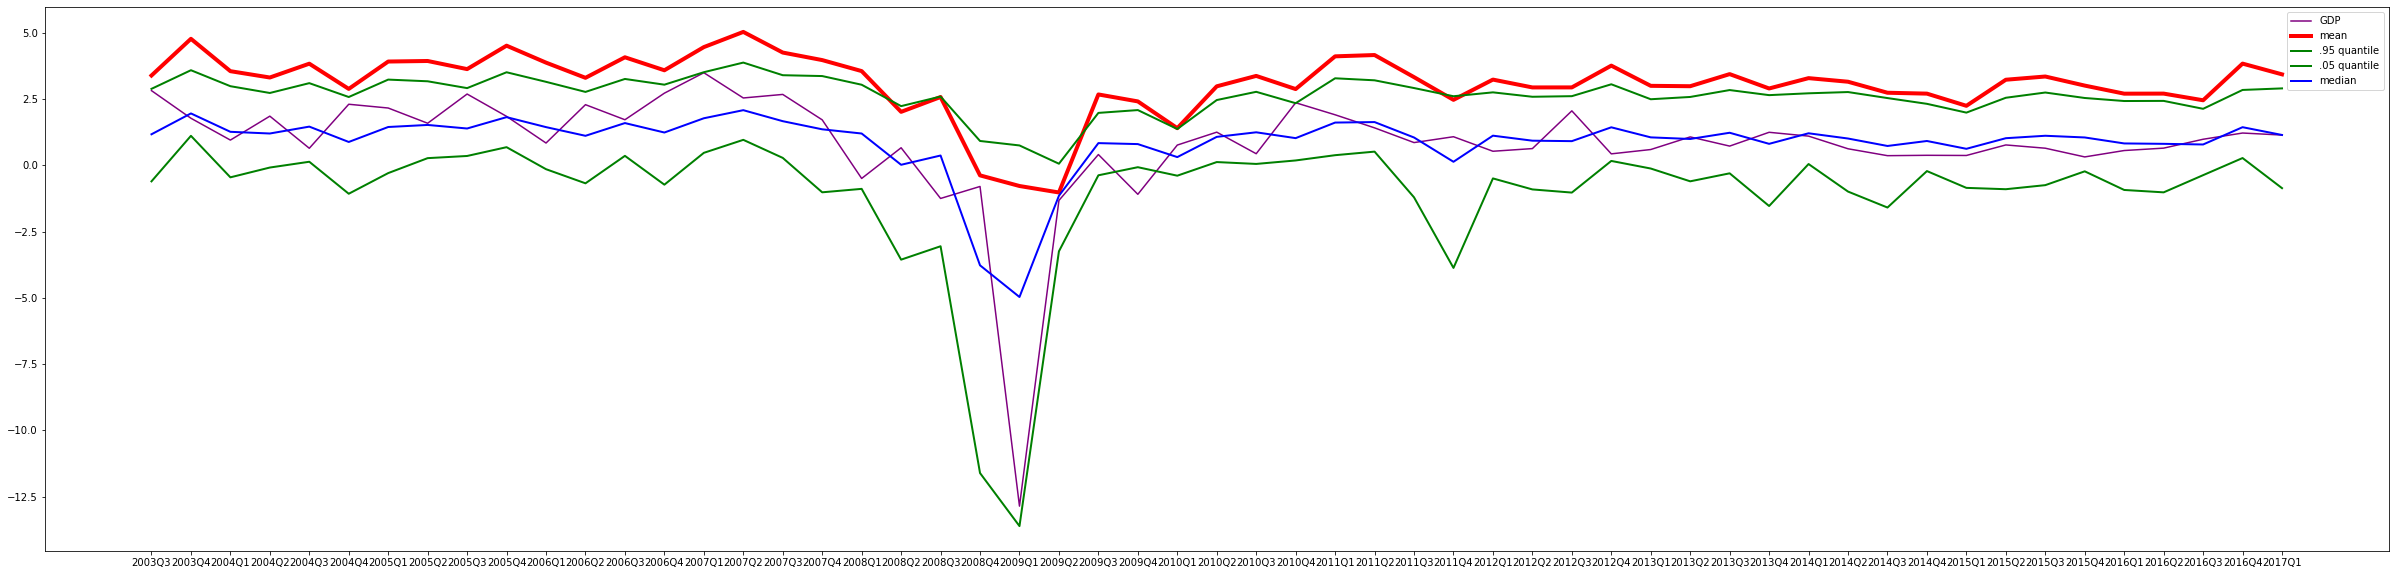

In [44]:
plt.figure(figsize=[42, 10])  # inches
real_y = (data['Y_TRAIN'].squeeze()*scaler['std'][0] + scaler['mean'][0])*100
m = (m*scaler['std'][0] + scaler['mean'][0])*100
plt.plot(real_y, label='GDP', color='purple');
plt.plot(m, 'r', linewidth=4, label='mean');
upper = (np.array(dist.quantile(0.95))*scaler['std'][0] + scaler['mean'][0])*100
lower = (np.array(dist.quantile(0.05))*scaler['std'][0] + scaler['mean'][0])*100
median = (np.array(dist.quantile(0.5))*scaler['std'][0] + scaler['mean'][0])*100

plt.plot(upper, 'g', linewidth=2, label=r'.95 quantile');
plt.plot(lower, 'g', linewidth=2, label=r'.05 quantile');
plt.plot(median, 'b', linewidth=2, label=r'median');


ax=plt.gca();
ax.set_xticks(range(len(data['TRAIN_DF'])-1))
ax.set_xticklabels(data['TRAIN_DF'].index.to_list()[1:])
#ax.xaxis.set_ticks_position('bottom')
#ax.yaxis.set_ticks_position('left')
#ax.spines['left'].set_position(('data', 0))
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.legend()

#plt.savefig('charts/direct_density_estimation_train_set.png')

In [45]:
data['Y_TEST'].shape

(18, 1)